In [1]:
from glob import glob
import os

# Root of your dataset (has train/val/test with images/labels)
DATASET_DIR = "/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale"

# Collect images from train/val/test (if present), else fallback to recursive scan
splits = ["train", "val", "test"]
exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

file_list = []
for split in splits:
    split_dir = os.path.join(DATASET_DIR, split, "images")
    if os.path.isdir(split_dir):
        imgs = []
        for ext in exts:
            imgs += glob(os.path.join(split_dir, f"*{ext}"))
        file_list += imgs

# Fallback: recursive scan if no split folders were found
if not file_list:
    for root, _, files in os.walk(DATASET_DIR):
        for f in files:
            if f.lower().endswith(exts):
                file_list.append(os.path.join(root, f))

file_list = sorted(file_list)
print(f"✅ Found {len(file_list)} images")
print("\n".join(file_list[:5]))


✅ Found 234 images
/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_1284_png.rf.45c8239cf68c001ba91d7d002729eec7.jpg
/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_1326_png.rf.6019c7e15df84d9d6286932d03e687b6.jpg
/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_145_png.rf.a69d928d011a93d25a95b7b8380ea25d.jpg
/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_182_png.rf.c9539857a1608ea4850d37195ff767ce.jpg
/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_212_png.rf.2ffb29b8c57630c49b7ee34bce2c46f3.jpg


In [2]:
import pandas as pd
import os

def yolo_label_for_image(img_path):
    # Map images/.../name.jpg -> labels/.../name.txt
    split = "train" if "/train/" in img_path else "val" if "/val/" in img_path else "test" if "/test/" in img_path else None
    if split is None:
        return -1  # unknown split → no label
    labels_txt = os.path.join(
        DATASET_DIR, split, "labels",
        os.path.splitext(os.path.basename(img_path))[0] + ".txt"
    )
    if not os.path.exists(labels_txt):
        return 0
    try:
        with open(labels_txt, "r") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        # If there is at least one YOLO line => consider it a positive
        return 1 if len(lines) > 0 else 0
    except Exception:
        return 0

# Build labels_df compatible with your main loop (filename, label)
if file_list:
    labels_df = pd.DataFrame({
        "filename": file_list,
        "label": [yolo_label_for_image(p) for p in file_list]
    })
    print(labels_df.head())
else:
    labels_df = None


                                            filename  label
0  /kaggle/input/dataset-mouna-1/Dataset-Fracture...      1
1  /kaggle/input/dataset-mouna-1/Dataset-Fracture...      1
2  /kaggle/input/dataset-mouna-1/Dataset-Fracture...      1
3  /kaggle/input/dataset-mouna-1/Dataset-Fracture...      0
4  /kaggle/input/dataset-mouna-1/Dataset-Fracture...      0


In [3]:
import cv2
import numpy as np
import os

def save_overlay(gray_img, mask_uint8, out_path):
    """Save a nice colored overlay (mask in red) on top of grayscale image."""
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    base = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    color = base.copy()
    color[mask_uint8.astype(bool)] = [0, 0, 255]  # red
    overlay = cv2.addWeighted(base, 0.75, color, 0.25, 0)
    cv2.imwrite(out_path, overlay)


In [4]:
# Cell 1: Imports
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage import exposure, morphology, filters, feature, measure
from skimage.morphology import disk, square, rectangle
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy import ndimage as ndi
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import zipfile


os.makedirs('/kaggle/working/output/images', exist_ok=True)
os.makedirs('/kaggle/working/output/models', exist_ok=True)

## --- Full preprocessing + morphological enhancement ---


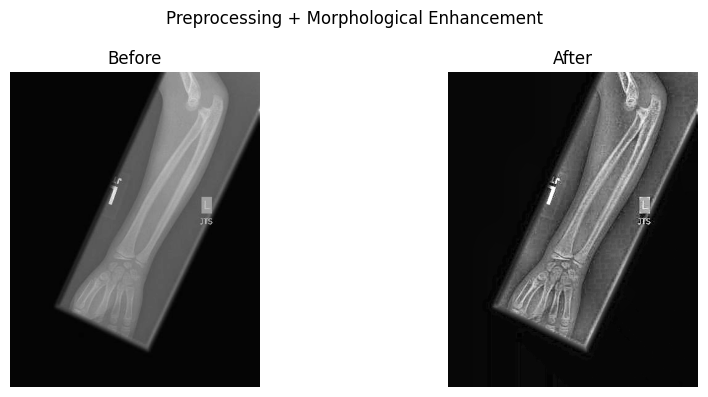

Saved -> /kaggle/working/output/images/sample_preprocessed.png


In [5]:
import cv2, numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import white_tophat, black_tophat, disk

# Display before & after helper
def show_before_after(original, processed, title="Preprocessing Example"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(original, cmap='gray'); plt.title("Before"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(processed, cmap='gray'); plt.title("After"); plt.axis('off')
    plt.suptitle(title); plt.tight_layout(); plt.show()

# Full preprocessing + morphological enhancement
def preprocess(img, apply_clahe=True, denoise=True, morph_enhance=True):
    out = img.copy()

    if denoise:
        sigma_est = np.mean(estimate_sigma(out, channel_axis=None))
        patch_kw = dict(patch_size=5, patch_distance=6, channel_axis=None)
        out = denoise_nl_means(out, h=1.15*sigma_est, fast_mode=True, **patch_kw)
        out = (np.clip(out, 0, 1)*255).astype(np.uint8)

    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        out = clahe.apply(out)

    if morph_enhance:
        se = disk(5)
        tophat = white_tophat(out, se)
        bottomhat = black_tophat(out, se)
        out = out.astype(np.int16) + tophat.astype(np.int16) - bottomhat.astype(np.int16)
        out = np.clip(out, 0, 255).astype(np.uint8)

    return out

# --- Test on one image ---
img_path = "/kaggle/input/dataset-mouna-1/Dataset-Fractures-bras-finale/test/images/image1_1284_png.rf.45c8239cf68c001ba91d7d002729eec7.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, f"Could not read image: {img_path}"

processed = preprocess(img)
show_before_after(img, processed, title="Preprocessing + Morphological Enhancement")

# (optional) save the processed result
cv2.imwrite("/kaggle/working/output/images/sample_preprocessed.png", processed)
print("Saved -> /kaggle/working/output/images/sample_preprocessed.png")


# --- Fracture Candidate Detection Heuristics ---


In [6]:
from skimage import feature, morphology, measure
from scipy import ndimage as ndi
import numpy as np

def detect_fracture_candidates(img, bone_mask):
    """
    img: preprocessed uint8 grayscale image
    bone_mask: binary mask of the segmented bone
    returns: list of candidate fracture regions (dicts)
    """

    # 1️⃣ Edge map
    edges = feature.canny(img, sigma=1.0)
    edges = morphology.binary_dilation(edges, morphology.disk(1))

    # 2️⃣ Skeletonize bone and find discontinuities
    skeleton = morphology.skeletonize(bone_mask)
    skeleton_uint = skeleton.astype('uint8')

    # Count neighbors with convolution
    neigh = ndi.convolve(skeleton_uint, np.ones((3, 3)), mode='constant')

    # Endpoints: skeleton pixel with 1 neighbor
    endpoints_map = ((skeleton_uint == 1) & (neigh == 2))
    # Branch points: >=3 neighbors
    branch_map = ((skeleton_uint == 1) & (neigh >= 4))

    # 3️⃣ Contour analysis on bone
    contours = measure.find_contours(bone_mask, 0.5)
    candidates = []

    for cnt in contours:
        cnt = np.array(cnt, dtype=np.int32)
        if cnt.shape[0] < 30:
            continue

        # Local curvature via second derivative
        dx = np.gradient(cnt[:, 1])
        dy = np.gradient(cnt[:, 0])
        ddx = np.gradient(dx)
        ddy = np.gradient(dy)
        curvature = np.abs(ddx * dy - ddy * dx) / (dx * dx + dy * dy + 1e-6)

        # High curvature peaks → possible discontinuities
        peaks = np.where(curvature > np.percentile(curvature, 95))[0]
        for p in peaks:
            y, x = cnt[p]
            if edges[y, x]:  # ensure near edge
                # Create small bounding box around point
                r = 15
                y0, y1 = max(0, y - r), min(img.shape[0], y + r)
                x0, x1 = max(0, x - r), min(img.shape[1], x + r)

                roi_mask = bone_mask[y0:y1, x0:x1]
                roi_img = img[y0:y1, x0:x1]

                # Simple features
                area = np.sum(roi_mask)
                mean_grad = np.mean(np.hypot(*np.gradient(roi_img.astype('float32'))))

                candidates.append({
                    'y': int(y),
                    'x': int(x),
                    'area': float(area),
                    'mean_grad': float(mean_grad),
                    'bbox': (int(x0), int(y0), int(x1), int(y1))
                })

    return candidates
       # 4️⃣ Merge close candidates (within 20px)
    merged = []
    for c in candidates:
        merged_flag = False
        for m in merged:
            if np.hypot(c['x'] - m['x'], c['y'] - m['y']) < 20:
                # average positions
                m['x'] = int((m['x'] + c['x']) / 2)
                m['y'] = int((m['y'] + c['y']) / 2)
                m['area'] += c['area']
                merged_flag = True
                break
        if not merged_flag:
            merged.append(c)

    return merged


## --- Segmentation + Morphological cleanup  ---


In [7]:
import numpy as np
import cv2
from skimage import filters, morphology, feature, segmentation
from scipy import ndimage as ndi
from skimage.morphology import disk

def segment_bone(img):
    """
    img: preprocessed uint8 grayscale
    returns: binary mask (uint8) of main bone structure
    """
    # 1️⃣ Otsu threshold
    th = filters.threshold_otsu(img)
    bw = img > th

    # 2️⃣ Morphological cleanup
    bw = morphology.closing(bw, disk(3))
    bw = morphology.remove_small_holes(bw, area_threshold=500)
    bw = morphology.remove_small_objects(bw, min_size=500)

    # 3️⃣ Distance transform + Watershed
    distance = ndi.distance_transform_edt(bw)
    coords = feature.peak_local_max(
        distance,
        labels=bw,
        footprint=np.ones((15, 15), dtype=bool),
        exclude_border=False
    )
    local_maxi = np.zeros_like(bw, dtype=bool)
    if coords.size > 0:
        local_maxi[tuple(coords.T)] = True
    markers = ndi.label(local_maxi)[0]
    labels_ws = segmentation.watershed(-distance, markers, mask=bw)

    # 4️⃣ Keep only the largest connected component
    if labels_ws.max() == 0:
        return bw.astype(np.uint8)

    largest_label = np.argmax(np.bincount(labels_ws.flat)[1:]) + 1
    bone_mask = (labels_ws == largest_label)
    return bone_mask.astype(np.uint8)


## --- Feature extraction for classification ---


In [8]:
from skimage import measure, feature
import numpy as np

def extract_features_from_candidate(img, bone_mask, cand):
    """
    Extracts numerical features from a fracture candidate region.
    Returns a list of features:
    [area, mean_intensity, gradient, edge_density, solidity, extent]
    """

    # 1️⃣ Crop region of interest (ROI)
    x0, y0, x1, y1 = cand['bbox']
    roi = img[y0:y1, x0:x1]
    roi_mask = bone_mask[y0:y1, x0:x1]

    # 2️⃣ Basic region properties
    props = measure.regionprops((roi_mask > 0).astype('uint8'))
    area = np.sum(roi_mask)
    mean_intensity = np.mean(roi[roi_mask > 0]) if area > 0 else np.mean(roi)

    # 3️⃣ Gradient magnitude (edge sharpness)
    gradient = np.mean(np.hypot(*np.gradient(roi.astype('float32'))))

    # 4️⃣ Edge density (edges per pixel)
    edges = feature.canny(roi, sigma=1.0)
    edge_density = np.sum(edges) / (roi.size + 1e-6)

    # 5️⃣ Solidity and extent if region found
    solidity = 0
    extent = 0
    if props:
        p = props[0]
        solidity = p.solidity
        extent = p.extent

    # 6️⃣ Return feature vector
    return [area, mean_intensity, gradient, edge_density, solidity, extent]


processed = preprocess(img)
bone_mask = segment_bone(processed)
cands = detect_fracture_candidates(processed, bone_mask)
features = [extract_features_from_candidate(processed, bone_mask, c) for c in cands]
print("Feature matrix shape:", np.array(features).shape)


Feature matrix shape: (6, 6)


## --- Main pipeline applied to dataset ---


In [9]:
results = []
features = []
feature_labels = []

for idx, fname in enumerate(file_list):
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Could not read {fname}")
        continue

    # 1) Preprocessing
    pre = preprocess(img)
    bone_mask = segment_bone(pre)

    # 2) Fracture candidate detection on the enhanced image
    cands = detect_fracture_candidates(pre, bone_mask)
    detected = 1 if len(cands) > 0 else 0

    # 3) Optional: ground-truth label
    label = None
    if 'labels_df' in globals() and labels_df is not None:
        m = labels_df[labels_df['filename'] == fname]
        if len(m) > 0:
            label = int(m.iloc[0]['label'])

    # 4) Visualization & save overlay
    outimg = f'/kaggle/working/output/images/{os.path.basename(fname)}'
    cand_mask = np.zeros_like(bone_mask, dtype=np.uint8)
    for c in cands:
        x, y = c['x'], c['y']
        cv2.circle(cand_mask, (x, y), 10, 1, -1)
    save_overlay(img, (bone_mask.astype(np.uint8) | cand_mask.astype(np.uint8)), outimg)

    # 5) Log global image results
    results.append({
        'filename': fname,
        'detected': detected,
        'n_candidates': len(cands),
        'label': label
    })

    # 6) Extract features per candidate (use the same image you detected on)
    for c in cands:
        feats = extract_features_from_candidate(pre, bone_mask, c)
        features.append(feats)
        feature_labels.append(label if label is not None else -1)

# 7) Save summary CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/kaggle/working/output/results_summary.csv', index=False)
print('✅ Saved results_summary.csv')

# 8) Train classifier if labeled data is available
if 'labels_df' in globals() and labels_df is not None and len(features) > 20:
    feat_arr = np.array(features)
    lbls = np.array(feature_labels)
    valid_idx = lbls != -1
    X = feat_arr[valid_idx]
    y = lbls[valid_idx]

    if len(np.unique(y)) > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print('🧠 Classifier report:')
        print(classification_report(y_test, y_pred))
        joblib.dump(clf, '/kaggle/working/output/models/rf_fracture.pkl')
        print('✅ Saved model to /kaggle/working/output/models/rf_fracture.pkl')

# 9) Zip outputs
zipf = zipfile.ZipFile('/kaggle/working/output/fracture_outputs.zip', 'w', zipfile.ZIP_DEFLATED)
for root, dirs, files in os.walk('/kaggle/working/output'):
    for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file), '/kaggle/working/output'))
zipf.close()
print('📦 Zipped all outputs to /kaggle/working/output/fracture_outputs.zip')


✅ Saved results_summary.csv
🧠 Classifier report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.67       135
           1       0.83      0.93      0.88       294

    accuracy                           0.82       429
   macro avg       0.81      0.76      0.77       429
weighted avg       0.82      0.82      0.81       429

✅ Saved model to /kaggle/working/output/models/rf_fracture.pkl
📦 Zipped all outputs to /kaggle/working/output/fracture_outputs.zip


##  Visualize some examples (first 6)


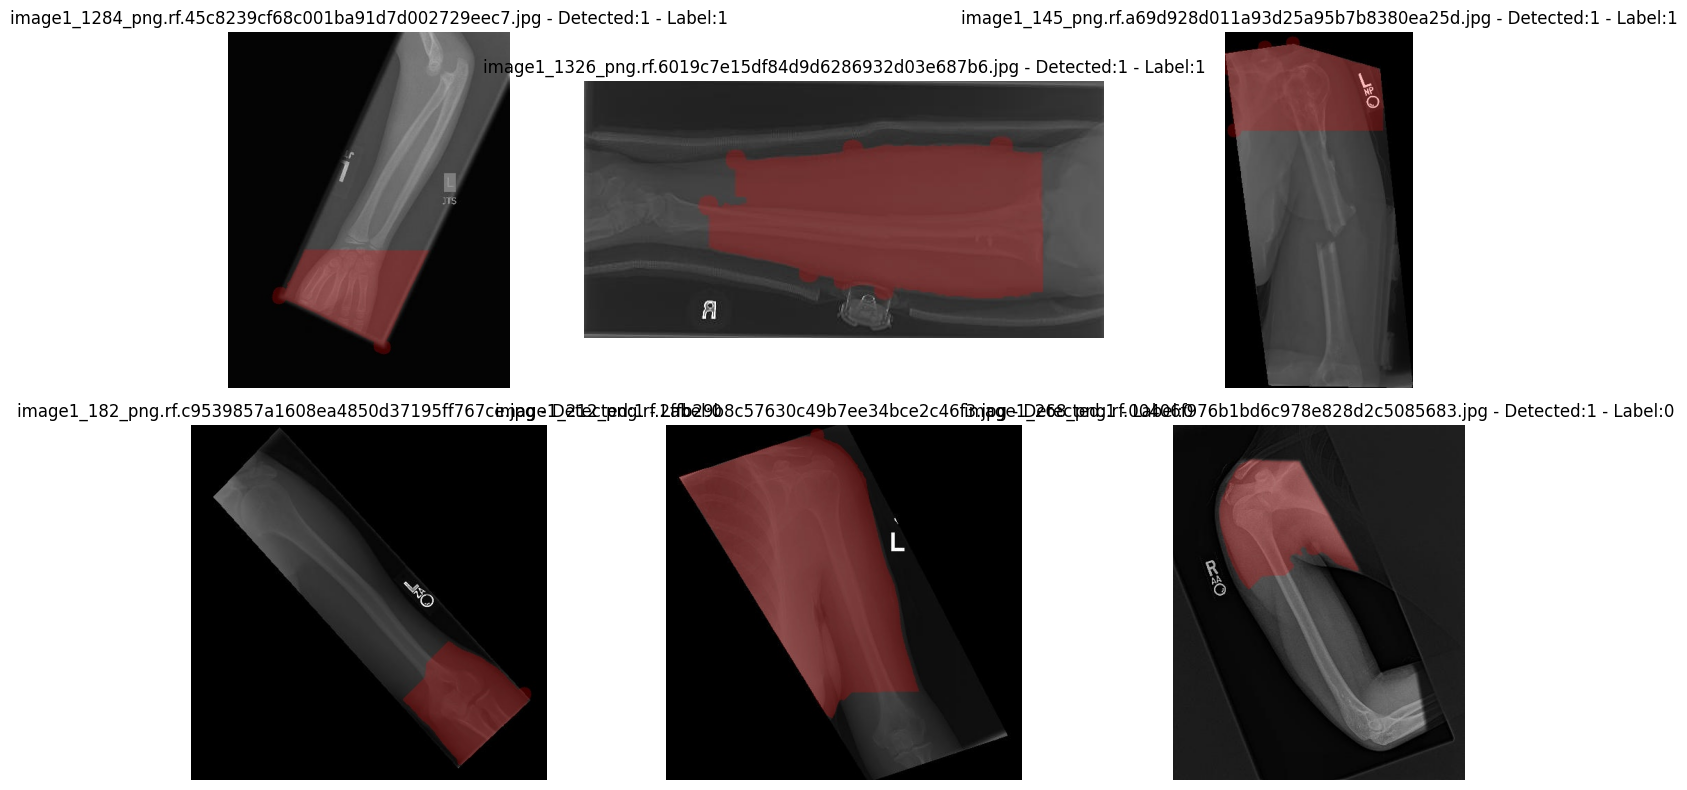

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_examples(n=6):
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()

    for i, row in enumerate(results_df.head(n).itertuples(index=False)):
        img_path = os.path.join('/kaggle/working/output/images', os.path.basename(row.filename))
        img = cv2.imread(img_path)
        if img is None:
            axs[i].set_title(f"Missing: {os.path.basename(row.filename)}")
            axs[i].axis('off')
            continue

        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        title = f"{os.path.basename(row.filename)} - Detected:{row.detected}"
        if hasattr(row, 'label') and not pd.isna(row.label):
            title += f" - Label:{int(row.label)}"

        axs[i].set_title(title)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# 🔍 Run to display example overlay results
show_examples()
